In [18]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader, VessMapDataset

torch.cuda.empty_cache()
device = torch.device("cuda")

In [19]:
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

In [20]:
# Initialize empty lists to store data
all_images = []
all_masks = []
all_skeletons = []

for batch in train_loader:
        images, masks, skeletons = batch
        all_images.extend(images)
        all_masks.extend(masks)
        all_skeletons.extend(skeletons)
        
for batch in test_loader:
        images, masks, skeletons = batch
        all_images.extend(images)
        all_masks.extend(masks)
        all_skeletons.extend(skeletons)

In [21]:
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model_regularized_l1 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l1.load_state_dict(torch.load(f"../models/vess_map_regularized_l1_200.pth"))

model_regularized_l2 = CustomResNet(num_classes=2).to(device)
# Load the weights
model_regularized_l2.load_state_dict(torch.load(f"../models/vess_map_regularized_l2_200.pth"))

model = model.eval()
model_regularized_l1 = model_regularized_l1.eval()
model_regularized_l2 = model_regularized_l2.eval()

models = [model, model_regularized_l1, model_regularized_l2]
models_name = ['vess_map_regularized_none_200', 'vess_map_regularized_l1_200', 'vess_map_regularized_l2_200']

In [22]:
def positive_score(out, target = 1):
  search_domain = out[0, :, :]
  
  for i in range(100, search_domain.shape[0]):
        for j in range(100, search_domain.shape[1]):
            if search_domain[i, j] > 0:
                return (i, j)
  return None
  skeleton
def compute_gradient_at_coordinates(model, image, skeleton):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Get the score at the specified coordinates for class 1
    x, y = positive_score(skeleton, 1)
    score = out[0, 1, x, y]

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad, x, y

In [23]:
import json
import base64
import numpy as np
import torch

def convert_to_base64(tensor):
    # Convert a tensor to a base64 encoded string
    return base64.b64encode(tensor.detach().cpu().numpy()).decode('utf-8')

def save_gradient(model, model_name):
    # Dictionary to hold all data
    data_to_save = []

    for i in range(len(all_images)):
        gradient, x, y = compute_gradient_at_coordinates(model, all_images[i].to(device), all_skeletons[i].to(device))
        mask = all_masks[i]

        data_dict = {
            'image': convert_to_base64(all_images[i]),
            'mask': convert_to_base64(mask),
            'gradient': convert_to_base64(gradient.squeeze(0)),
            'coordinates': {'x': x, 'y': y}
        }
        
        data_to_save.append(data_dict)

    # Serialize to JSON and save to a file
    with open(f"../data/gradients/gradient_data_{model_name}.json", 'w') as file:
        json.dump(data_to_save, file)

In [24]:
for i in range(len(models)):
  save_gradient(models[i], models_name[i])

100


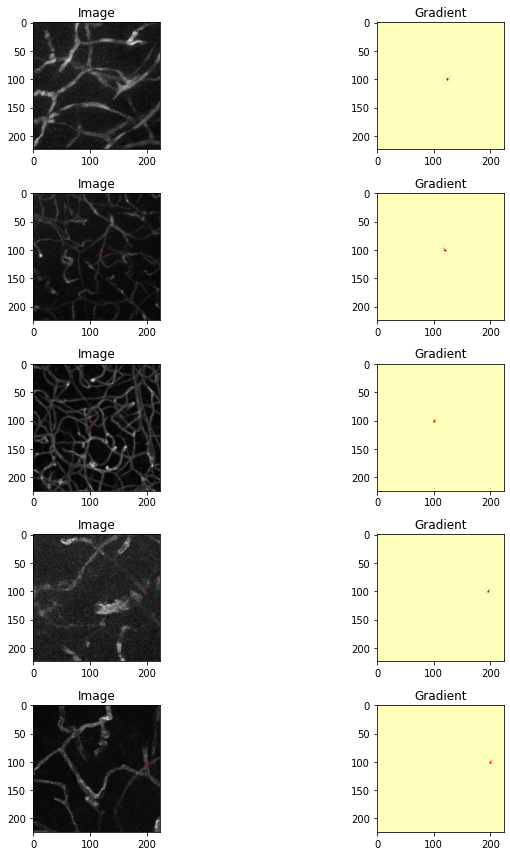

In [26]:
import matplotlib.pyplot as plt
import json
import numpy as np
import base64
import torch

def convert_from_base64(base64_str):
    # Convert a base64 encoded string back to a numpy array
    return np.frombuffer(base64.b64decode(base64_str), dtype=np.float32).reshape(224, 224)

# Read data from JSON file
with open("../data/gradients/gradient_data.json", 'r') as file:
    loaded_data = json.load(file)

print(len(loaded_data))
# Select the first five data entries for plotting
data_to_plot = loaded_data[:5]

fig, axes = plt.subplots(nrows=len(data_to_plot), ncols=2, figsize=(12, 12))

for i, data in enumerate(data_to_plot):
    image = convert_from_base64(data['image'])
    gradient = convert_from_base64(data['gradient'])
    x, y = data['coordinates']['x'], data['coordinates']['y']

    # Plot each component
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].scatter(y, x, color='red', s=1)  # Scatter on image
    axes[i, 0].set_title('Image')

    v_max = np.abs(gradient).max()
    axes[i, 1].imshow(gradient, cmap='RdYlGn', vmin=-v_max, vmax=v_max, interpolation='nearest')

    axes[i, 1].scatter(y, x, color='red', s=1)  # Scatter on gradient
    axes[i, 1].set_title('Gradient')

plt.tight_layout()
plt.show()